- [ ] Try to overfit earlier
    * Try adding more layers

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pywt
from scipy import signal
from tqdm import tqdm

%matplotlib inline

## Load data

In [2]:
data_path = "Data/GeneratedData/combined_data/"
base_path = os.getcwd()

# REST
# IDD = np.load(os.path.join(data_path, "IDD_rest.npy"))
# TDC = np.load(os.path.join(data_path, "TDC_rest.npy"))

# MUSIC
IDD = np.load(os.path.join(data_path, "IDD_music.npy"))
TDC = np.load(os.path.join(data_path, "TDC_music.npy"))

X = np.concatenate((TDC, IDD))
Y = [0]*len(TDC) + [1]*len(IDD)
Y = np.asarray(Y)

In [3]:
print(X.shape)
print(Y.shape)

(8470, 14, 256)
(8470,)


## Create Spectrograms

In [4]:
# Modified scalogram function from Fusion notebook
def scalogram(x, Hz, hz, num_secs, w = 5.):
    ''' x = time series
        Hz = sampling rate in Hz of the input signal
        hz = desired sampling rate (by downsampling)
        start_sec = starting second in x
        num_secs = total number of seconds of our clip
        w = width parameter
        log =raw_seiz if true take log of spectrum values
    '''
    
    downsample = int(round(Hz / hz))
    X = x[0: num_secs * Hz : downsample]


    t, dt = np.linspace(0, num_secs, hz * num_secs, retstep = True)
    fs = 1 / dt

    freq = np.linspace(1, fs / 2, int(hz / 2))
    widths = w * fs / (2 * np.pi * freq)

    cwtm = signal.cwt(X,
                      signal.morlet2,
                      widths,
                      w = w)
    
    return cwtm

In [5]:
def generate_scalogram(data, Hz, hz, num_secs, w = 5.):
    scalogram_data = np.zeros((data.shape[0], data.shape[1] * (hz // 2), hz * num_secs), dtype="complex128")
    for sample_index in tqdm(range(data.shape[0])):
        for channel_index in range(0, data.shape[1]):
            scalogram_data[sample_index][channel_index * (hz//2): channel_index * (hz//2) + hz//2] = \
            scalogram(data[sample_index][channel_index], 128, 64, 2)
    return scalogram_data

In [6]:
X_scalogram = generate_scalogram(X, 126, 64, 2)

100%|██████████| 8470/8470 [04:18<00:00, 32.81it/s]


In [7]:
X_scalogram.shape

(8470, 448, 128)

In [8]:
def plot_scalograms(data, sample_index, N=128, hz=64, T=2, ts=0, w=4.):
    """
    :param N: signal sampling rate
    :param hz: downsampled sampling rate
    :param T: seconds
    :param ts: starting second
    :param w: 
    """

    t, dt = np.linspace(ts, ts + T, hz * T, retstep = True)
    fs = 1 / dt

    freq = np.linspace(1, (14 * (fs / 2)), (14 * int(hz / 2)))
    
    print("Y label:", Y[sample_index])
    
    plt.rcParams['figure.figsize'] = 14, 30
    im = plt.pcolormesh(t, freq, np.abs(data[sample_index]), cmap = 'jet') # 'viridis'
    plt.show()


Y label: 0


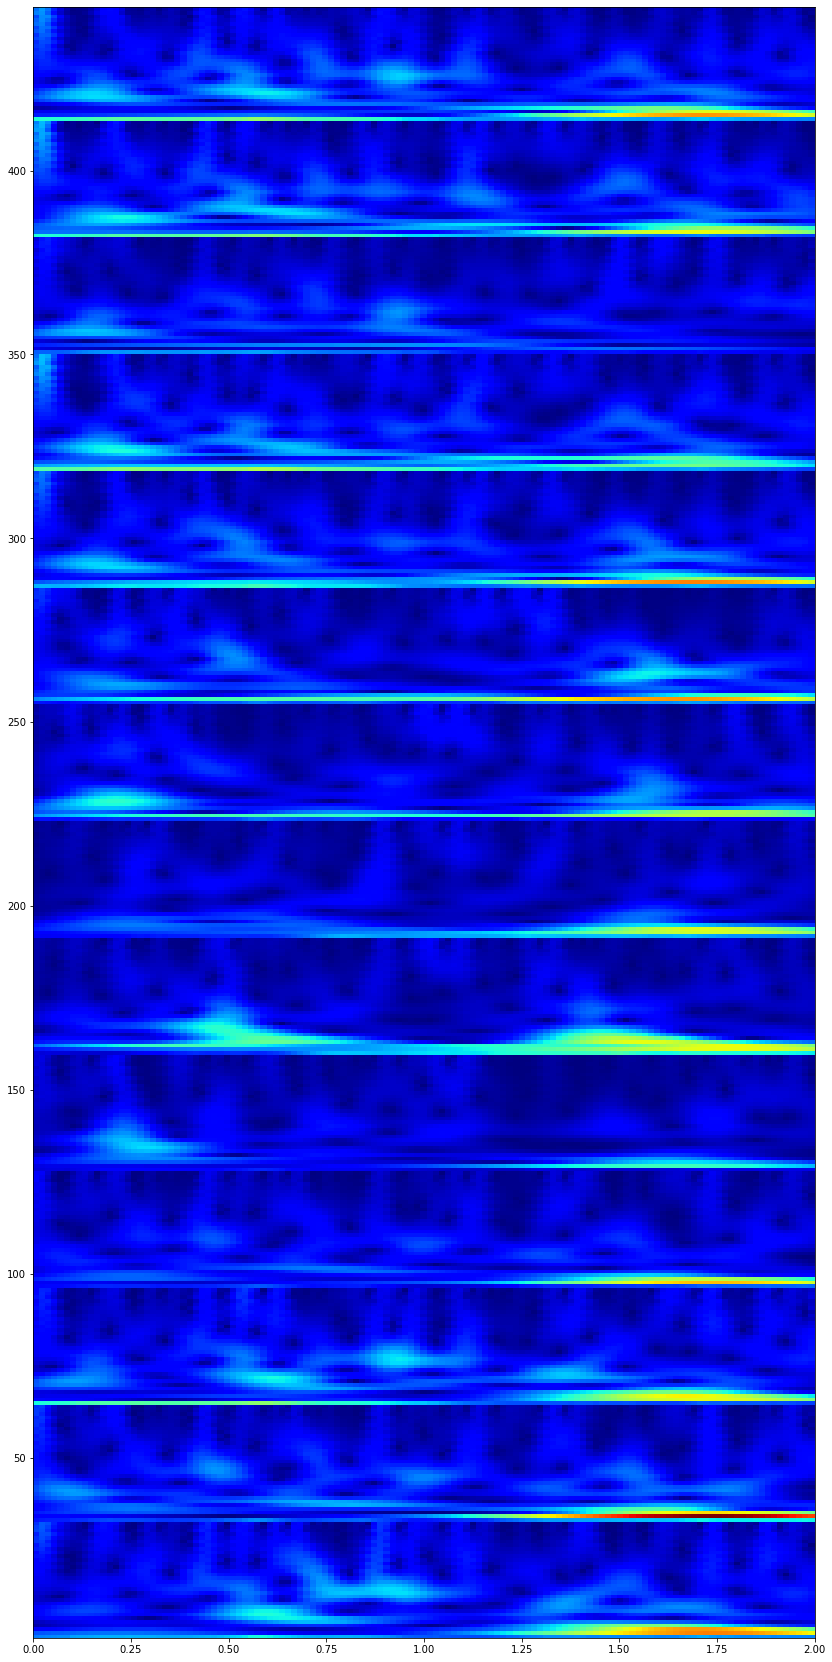

In [9]:
plot_scalograms(X_scalogram, 1000)

In [10]:
# reshape data
X_scalogram_shaped = X_scalogram.reshape(X_scalogram.shape[0], X_scalogram.shape[1], X_scalogram.shape[2], 1)
X_scalogram_shaped.shape

(8470, 448, 128, 1)

## Test-Train split

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_scalogram_shaped, Y, test_size=0.2, stratify=Y, random_state=42)

In [21]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
input_shape = X_train.shape[1:]

X_train shape: (6776, 448, 128, 1)
y_train shape: (6776,)
X_val shape: (1694, 448, 128, 1)
y_val shape: (1694,)


## Model

In [13]:
base_model = keras.Sequential([
    # Set input layer
    keras.layers.InputLayer(input_shape=input_shape),
    
    # Conv + Maxpooling
    keras.layers.Conv2D(8, (3, 3), padding="same", activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Normalization
    keras.layers.BatchNormalization(),
    
    # Flatten and convert from 3D to 1D
    keras.layers.Flatten(),
    
    # Sigmoid
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])


In [14]:
base_model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 448, 128, 8)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 224, 64, 8)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 64, 8)        32        
_________________________________________________________________
flatten (Flatten)            (None, 114688)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 114689    
Total params: 114,801
Trainable params: 114,785
Non-trainable params: 16
_________________________________________________________________


In [22]:
complex_model = keras.Sequential([
    # Set input layer
    keras.layers.InputLayer(input_shape=input_shape),
    
    # Conv + Maxpooling
    keras.layers.Conv2D(8, (2, 2), padding="same", activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(12, (3, 3), padding="same", activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Normalization
    keras.layers.BatchNormalization(),
    
    # Flatten and convert from 3D to 1D
    keras.layers.Flatten(),
    
    keras.layers.Dense(24, activation=tf.nn.relu),
    
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(12, activation=tf.nn.relu),
    
    
    # Sigmoid
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])


In [23]:
complex_model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)
complex_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 448, 128, 8)       40        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 224, 64, 8)        0         
_________________________________________________________________
dropout (Dropout)            (None, 224, 64, 8)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 224, 64, 12)       876       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 32, 12)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 112, 32, 12)       48        
_________________________________________________________________
flatten_2 (Flatten)          (None, 43008)            

In [30]:
log_reg = keras.Sequential([
    keras.layers.InputLayer(input_shape=input_shape),
    keras.layers.Flatten(),
    keras.layers.Dense(1, input_dim=input_shape, activation=tf.nn.sigmoid)
])

log_reg.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)
log_reg.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 57344)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 57345     
Total params: 57,345
Trainable params: 57,345
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = log_reg.fit(X_train, 
                    y_train, 
                    epochs=10, 
                    batch_size=128,
                    validation_data=(X_val, y_val), 
                    verbose=1)

Train on 6776 samples, validate on 1694 samples
Epoch 1/10
6776/6776 [==============================] - 18s 3ms/sample - loss: 15.0067 - accuracy: 0.4878 - val_loss: 14.7336 - val_accuracy: 0.4900
Epoch 2/10
6776/6776 [==============================] - 9s 1ms/sample - loss: 12.8376 - accuracy: 0.5409 - val_loss: 14.0401 - val_accuracy: 0.5100
Epoch 3/10
6776/6776 [==============================] - 3s 490us/sample - loss: 12.2892 - accuracy: 0.5401 - val_loss: 15.0643 - val_accuracy: 0.4882
Epoch 4/10
6776/6776 [==============================] - 3s 382us/sample - loss: 11.9232 - accuracy: 0.5580 - val_loss: 14.5136 - val_accuracy: 0.5000
Epoch 5/10
6776/6776 [==============================] - 2s 366us/sample - loss: 11.8331 - accuracy: 0.5574 - val_loss: 17.8723 - val_accuracy: 0.4841
Epoch 6/10
6776/6776 [==============================] - 3s 372us/sample - loss: 12.6417 - accuracy: 0.5595 - val_loss: 15.7932 - val_accuracy: 0.4953
Epoch 7/10
6776/6776 [==============================] -

* Base Model
    * Music
        * Validation accuracy: 99.47%
        * Validation loss: 0.0161
    * Rest
        * Validation accuracy: 99.53%
        * Validation loss: 0.0140
        
* Complex Model
    * Music
        * Validation accuracy: 100%
        * Validation loss: 6.9647e-04


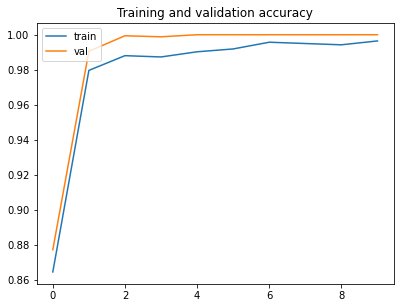

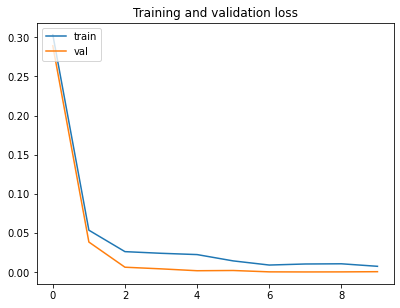

In [26]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))
plt.figure(figsize=(6.4,4.8))
# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')

plt.figure(figsize=(6.4,4.8))

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend(['train', 'val'], loc='upper left')